Compare the emission line data from GAMA to the emission line data from SDSS DR7 

In [1]:
import os
import subprocess
import numpy as np 

from astropy.io import fits 

from feasibgs import util as UT
from feasibgs import catalogs as Cat

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in GAMA-Legacy Catalog

In [3]:
# read in GAMA-Legacy catalog
cata = Cat.GamaLegacy()
gleg = cata.Read()

In [4]:
cataid = gleg['gama-photo']['cataid'] # GAMA catalog id of each object
ngal = len(cataid)

Read in GAMA SpecObj file

In [5]:
# read in GAMA SpecObj file 
f_specobj = fits.open(''.join([UT.dat_dir(), 'gama/SpecObj.fits']))
specobj_fits = f_specobj[1].data
specobj_cataid = specobj_fits.field("CATAID")

In [6]:
#only keep galaxies with SDSS spectra 
fromsdss = (specobj_fits.field('SURVEY') == 'SDSS')

In [7]:
cataid_common = np.intersect1d(cataid, specobj_cataid[fromsdss])

In [8]:
print('%i galaxies with SDSS spectra' % len(cataid_common)) 

55 galaxies with SDSS spectra


In [9]:
i_gleg = [] # idices of GAMA-Legacy objects with SDSS spectra
for i in range(len(cataid_common)): 
    i_gleg.append(np.arange(ngal)[cataid == cataid_common[i]])
i_gleg = np.array(i_gleg)

In [10]:
for i in range(len(cataid_common)): 
    url_i = specobj_fits.field('URL')[specobj_cataid == cataid_common[i]][0]
    f_i = url_i.split("/")[-1]
    f_i_local = ''.join([UT.dat_dir(), 'gama/spectra/', f_i])
    if not os.path.isfile(f_i_local): 
        print('getting %s' % f_i_local)
        cmd_getfile = ''.join(['curl -o ', f_i_local, ' ', url_i])
        subprocess.call(cmd_getfile.split())

In [12]:
sdss_emline = [] 
for i in range(len(cataid_common)): 
    url_i = specobj_fits.field('URL')[specobj_cataid == cataid_common[i]][0]
    fits_spec_i = fits.open(''.join([UT.dat_dir(), 'gama/spectra/', url_i.split("/")[-1]]))
    sdss_emline.append(fits_spec_i[2].data)

In [25]:
emline_index_sdss = [17, 18, 29, 30, 31, 36, 37, 38, 40, 41]
emline_key = ['oiib', 'oiir', 'hb', 'oiiib', 'oiiir', 'niib', 'ha', 'niir', 'siib', 'siir']

In [63]:
def emlineComparison(i_e): 
    fig = plt.figure(figsize=(8,4))
    sub1 = fig.add_subplot(121)
    sub2 = fig.add_subplot(122)    
    sdss_emline_height = np.zeros(len(cataid_common))
    sdss_emline_sigma = np.zeros(len(cataid_common))
    for i in range(len(cataid_common)): 
        sdss_emline_height[i] = sdss_emline[i]['height'][emline_index_sdss[i_e]]
        sdss_emline_sigma[i] = sdss_emline[i]['sigma'][emline_index_sdss[i_e]]
        
    gama_emline_integ = gleg['gama-spec'][emline_key[i_e]][i_gleg].flatten()
    gama_emline_iline = gleg['gama-spec']['i'+emline_key[i_e]][i_gleg].flatten()
    gama_emline_sigma = gleg['gama-spec'][emline_key[i_e]+'sig'][i_gleg].flatten()

    hasemline = (sdss_emline_height != -9999.) & (sdss_emline_sigma != -9999.) & (gama_emline_integ != -99.)
    sdss_emline_integ = sdss_emline_height[hasemline] * sdss_emline_sigma[hasemline] * np.sqrt(np.pi)
    sub1.scatter(gama_emline_integ[hasemline], sdss_emline_integ)
    sub1.scatter(gama_emline_iline[hasemline], sdss_emline_integ, c='C1')
    sub1.plot([-50., 1000.], [-50., 1000.], c='k', ls='--')
    sub1.set_xlabel('GAMA '+emline_key[i_e].upper()+' line flux')
    sub1.set_ylabel('SDSS '+emline_key[i_e].upper()+' line flux')
    sub1.set_xlim([-50., 1000.])
    sub1.set_ylim([-50., 500.])
    
    sub2.scatter(gama_emline_sigma[hasemline], sdss_emline_sigma[hasemline])
    sub2.plot([-10., 20.], [-10., 20.], c='k', ls='--')
    sub2.set_xlabel('GAMA '+emline_key[i_e].upper()+' $\sigma$')
    sub2.set_ylabel('SDSS '+emline_key[i_e].upper()+' $\sigma$')
    
    sub2.set_xlim([0., 10])
    sub2.set_ylim([0., 10])
    plt.show()

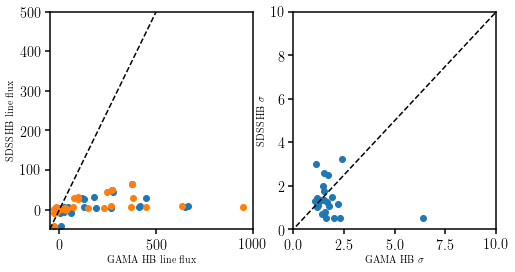

In [64]:
emlineComparison(2)

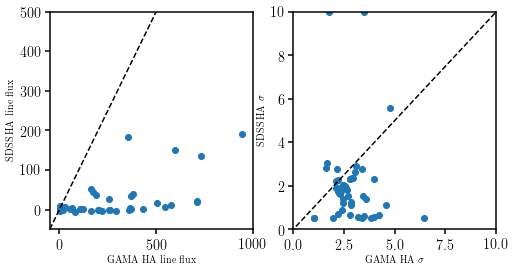

In [61]:
emlineComparison(6)